# Optimal radial basis construction

This notebook provides a discussion, and a practical example of the application, of the construction of a data-driven optimal radial basis to expand the atom-centered neighbor density. 
See [REF] for a discussion of the idea and implementation.

In [1]:
from ase.io import read
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis

## Loads the structures

In [2]:
import urllib.request
# a collection of distorted ethanol molecules from the ANI-1 dataset 
# (see https://github.com/isayev/ANI1_dataset) with energies and forces computed using DFTB+ 
# (see https://www.dftbplus.org/)
url = 'https://raw.githubusercontent.com/cosmo-epfl/librascal-example-data/833b4336a7daf471e16993158322b3ea807b9d3f/inputs/molecule_conformers_dftb.xyz'
# Download the file from `url`, save it in a temporary directory and get the
# path to it (e.g. '/tmp/tmpb48zma.txt') in the `structures_fn` variable:
structures_fn, headers = urllib.request.urlretrieve(url)
structures_fn

'/tmp/tmp_cv1an3n'

In [4]:
# Total number of structure to load
N = 100

# load the structures
frames = read(structures_fn,':{}'.format(N))

## Demonstrate the optimization

first, we compute the density expansion coefficients on a representative dataset

In [5]:
spherical_expansion_hypers = {
    "interaction_cutoff": 3,
    "max_radial": 30,
    "max_angular": 8,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "DVR",
}

spex = SphericalExpansion(**spherical_expansion_hypers)

In [6]:
%%time
feats = spex.transform(frames).get_features_by_species(spex)

CPU times: user 94.2 ms, sys: 77.1 ms, total: 171 ms
Wall time: 175 ms


rotation-invariant covariant matrices are computed separately for each species and angular channel
then principal components are computed

In [7]:
%%time
cov = get_radial_basis_covariance(spex, feats)

CPU times: user 523 ms, sys: 427 ms, total: 950 ms
Wall time: 140 ms


In [8]:
%%time
p_val, p_vec = get_radial_basis_pca(cov)

CPU times: user 103 ms, sys: 126 ms, total: 229 ms
Wall time: 57.9 ms


we can visualize the convergence of the principal components. hint: it's FAST!

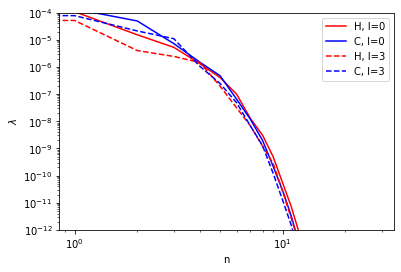

In [9]:
plt.loglog(p_val[(1,)][0], 'r', label="H, l=0")
plt.loglog(p_val[(1,)][3], 'b', label="C, l=0")
plt.loglog(p_val[(6,)][0], 'r--', label="H, l=3")
plt.loglog(p_val[(6,)][3], 'b--', label="C, l=3")
plt.ylim(1e-12,1e-4)
plt.xlabel("n")
plt.ylabel("$\lambda$")
plt.legend()

the principal components can be used as projectors to compute a contracted basis. 10 components are (way) more than enough!

In [10]:
p_mat = get_radial_basis_projections(p_vec, 10)

In [11]:
spherical_expansion_optimal_hypers = {
    "interaction_cutoff": 3,
    "max_radial": 10,
    "max_angular": 8,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "DVR",
    "optimization" : {
        "RadialDimReduction" : {"projection_matrices": p_mat},
        "Spline" : {"accuracy": 1e-8}
    }
}

spex_optimal = SphericalExpansion(**spherical_expansion_optimal_hypers)

evaluation is much faster because the contracted features are computed directly

In [12]:
%%time
feats_optimal = spex_optimal.transform(frames).get_features(spex_optimal)

CPU times: user 75.6 ms, sys: 7.87 ms, total: 83.5 ms
Wall time: 81.7 ms


we can also see how these functions look like "in real space"

In [13]:
r_grid = np.linspace(1e-5,3.9,1000)
dvr = radial_basis.radial_basis_functions_dvr(r_grid,
                                              spherical_expansion_hypers["max_radial"],
                                              spherical_expansion_hypers["interaction_cutoff"],
                                              spherical_expansion_hypers["gaussian_sigma_constant"])

In [14]:
p_dvr_h = p_vec[(1,)][0,:,:10].T @ dvr

(-5.0, 5.0)

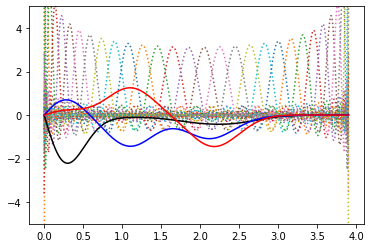

In [15]:
for y in dvr:
    plt.plot(r_grid, r_grid*y, ls=":")
plt.plot(r_grid, r_grid*p_dvr_h[0], 'k')
plt.plot(r_grid, r_grid*p_dvr_h[1], 'b')
plt.plot(r_grid, r_grid*p_dvr_h[2], 'r')
plt.ylim(-5,5)

... and this works equally well with GTOs (and optimal functions are the same!)

In [16]:
spherical_expansion_hypers.update({"radial_basis": "GTO", "max_radial":20})
spex = SphericalExpansion(**spherical_expansion_hypers)

feats = spex.transform(frames).get_features_by_species(spex)
cov = get_radial_basis_covariance(spex, feats)
p_val, p_vec = get_radial_basis_pca(cov)

In [17]:
gto = radial_basis.radial_basis_functions_gto(r_grid,
                                              spherical_expansion_hypers["max_radial"],
                                              spherical_expansion_hypers["interaction_cutoff"])
p_gto_h = p_vec[(1,)][0,:,:10].T @ gto

(-5.0, 5.0)

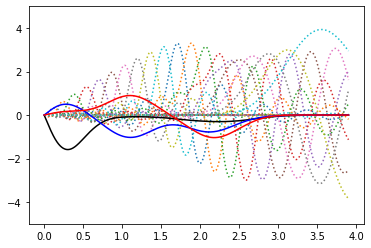

In [18]:
for y in gto:
    plt.plot(r_grid, r_grid*y, ls=":")
plt.plot(r_grid, p_gto_h[0], 'k')
plt.plot(r_grid, p_gto_h[1], 'b')
plt.plot(r_grid, -p_gto_h[2], 'r')
plt.ylim(-5,5)

## Streamlined helper function

If you don't need diagnostics, you can also use a simple helper function that takes your desired hypers, and builds a compatible optimal basis, optimizing on the given ase.Atoms frames

In [20]:
soap_hypers = {
    "soap_type": "PowerSpectrum",
    "interaction_cutoff": 3,
    "max_radial": 8,
    "max_angular": 5,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "normalize": False
}

idea is very simple: you take hypers, and a set of reference structures, and it returns the same hypers with optimized radial function. the number of contracted functions is that specified by `max_radial`, and the auxiliary basis functions are those indicated by `expanded_max_radial`

In [22]:
soap_hypers = get_optimal_radial_basis_hypers(soap_hypers, frames, expanded_max_radial=20)
'RadialDimReduction' in soap_hypers['optimization']

True

these can be used to define a `SphericalInvariants` calculator

In [23]:
soap_optimal = SphericalInvariants(**soap_hypers)

if there is a very large dataset, it is also possible to compute the covariance in blocks, by passing a list of lists rather than just a list of frames. this avoids computing all the large n_max auxiliary features in one go

In [24]:
soap_hypers = get_optimal_radial_basis_hypers(soap_hypers, [frames[i:i+10] for i in range(0,100,10)], 
                                              expanded_max_radial=20)